# Fast Multipole Method

In previous assignment we discussed Barnes Hut Algorithm which has complexity $\mathcal{O}(\theta^{-d}N\log N)$. However, with different algorithms, we can further decrease the complexity to $\mathcal{O}(N)$. In the Barnes-Hut algorithm we performed interactions between particles and pseudoparticles (effectively a zero order multipole). In the Fast Multipole method, we perform interactions between pseudo particles and pseudo particles. 
<br/>
In order to do this, we need expansion techniques. Orginally in the paper from [Greengard/Rohlkin](https://www.sciencedirect.com/science/article/pii/0021999187901409), the Taylor expansion is used. However, this is complicated to derive specifically in 3d (see spherical harmonics). In this assignment we will use the the outer/inner ring approximation as described by [Anderson](https://epubs.siam.org/doi/abs/10.1137/0913055). Anderson uses Poisson formula instead of multipole exapnsions and derives the potential in form of integration. The integration can be performed via numerical intergration of an integral formula. 

##### Interesting side note
The Fast multipole method is in the [top 10 algorithms of 20th century](http://pi.math.cornell.edu/~ajt/presentations/TopTenAlgorithms.pdf).

## Basic approximations
**NOTE**: The derivation of all the formulas in the next sections is beyond the scope of this course
We consider coulomb's potential in 2-dimension represented as
$$U(r) = C \log r$$
where $C$ is a constant

### Outer ring approximation
Suppose we have a collection of charged particles inside a box. We choose a ring of radius $a$ around it. $a$  should be bigger than the box. In this exercise we take a ring radius to be equal to the side length of the square box. Now, we want to calculate the potential that is induced by all the particles inside the box on a point $A$ outside the ring. We will define the point $A$ using the spherical coordinates $(r, \theta)$ relative to the center of the box, as seen in the following figure.
<img src="figure/outer_ring.png"
     alt="Outer ring"
     style="float: center;" />

The potential on point $A$ is approximated as following:
$$\psi(r, \theta) = \int_{S^2} g(a\vec{s}) \left( \sum_{n=0}^{\infty} \left(\frac{a}{r} \right)^{n+1} Q(\vec{s},\vec{x_p}) \right)ds$$
We will trucate the inner sum to $M$ terms and use the trapezoidal rule for the surface integration. After simplification and ignoring the small terms, we get the following expression:
$$\psi(r, \theta) = \kappa \log(r) + \frac{1}{2 \pi} \sum_{i=1}^{K} f(s_i) \left[ \frac{1- (\frac{a}{r})^2}{1 - 2 (\frac{a}{r})cos(\theta - s_i) + (\frac{a}{r})^2} \right] h$$
Here, the integration points or quadrature points, shown in the figure above as circles on the ring, representend in radial coordinates as $(a, s_i)$ are equidistant on the ring with $h=2\pi a/K$. Furthermore, let  $\kappa=\sum_{i=1}^{n}q_i$ be the total charge inside the box, and $f(s_i) = \psi(a,s_i) - \kappa \log(a)$. $\psi(a,s_i)$ is the potential on the quadrature points $(a,s_i)$ induced by the particles in the box. In order to get an exact integration we need $K=2M + 1$ quadrature points.

### Inner ring approximation
Suppose we have a collection of charged particles inside a box $M_1$. We want to calculate the potential at a point $A$ inside box $M_2$ which is induced by the particles inside of $M_1$. We form the ring in the same way as for the outer ring approximation, and define the point $A$ using the spherical coordinates $(r, \theta)$ with orgin at center of box $M_2$. The potential inside $M_2$ can be expressed as the potential of points on the ring around $M_2$. Since the target point is inside the ring through with we are approximating, this is called inner ring approximation.  
<img src="./figure/inner_ring.png"
     alt="Inner ring"
     style="float: center;" />

The potential on point $A$ is approximated as following:
$$\psi(r, \theta) = \int_{S^2} g(a\vec{s}) \left( \sum_{n=0}^{\infty} \left(\frac{r}{a} \right)^{n+1} Q(\vec{s},\vec{x_p}) \right)ds$$
Again, we will trucate the inner sum to $M$ terms and use the trapezoidal rule for the surface integration. After simplification and ignoring the small terms, we get the following expression:
$$\psi(r, \theta) = \frac{1}{2 \pi} \sum_{i=1}^{K} \psi(a,s_i) \left[ \frac{1- (\frac{r}{a})^2}{1 - 2 (\frac{r}{a})cos(\theta - s_i) + (\frac{r}{a})^2} \right] h$$
Here, the integration points or quadrature points, shown in the figure above as circles on the ring, representend in radial coordinates as $(a, s_i)$ are equidistant on the ring with $h=2\pi a/K$. $\psi(a,s_i)$ is the potential on the quadrature points of $M_2$ due to the particles in the box $M_1$. In order to have exact integration we need $K=2M + 1$ quadrature points.

## Implementation

This notebook uses code from a few other python files that should be packaged with this.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams, patches
from tqdm import tqdm
import math

Definition of the potential:

In [2]:
def potential_function(x, y):
    return np.log(np.sqrt(x**2 + y**2))

Definition of a particle:

In [3]:
class Particle:
    
    """A particle modeled as a point".
    
    Arguments:
        coords: a two-element list, containing the 2d coordinates of the point.
        domain: the domain of random generated coordinates x,y default=1.0.
        m: mass
        origin: origin of the domain (used for random generation of positions)

    Attributes:
        x, y: coordinates of the particle.
        m: mass of the particle.
        phi: the potential of the particle.
    """
    
    def __init__(self, coords=[], domain=1.0, m=1.0, origin=[0,0]):
        if coords:
            assert len(coords) == 2, "the size of coords should be 2."
            self.x = coords[0]
            self.y = coords[1]
        else:
            self.x = (domain * np.random.random()) + origin[0]
            self.y = (domain * np.random.random()) + origin[1]
        self.m = m
        self.phi = 0.

    def distance(self, other):
        return np.sqrt((self.x-other.x)**2 + (self.y-other.y)**2)
        
    def plot(self, marker='o', color='r', s=2):
        plt.scatter(self.x, self.y, marker=marker, color=color, s=s)


Definition of a cell:

In [4]:
class Cell():
    
    """The class for a cell.
    
    Arguments:
        n_crit: maximum number of particles in a leaf cell.
    
    Attributes:
        nparticles (int): number of particles in the cell
        particle_index (array of int): array of particles
        nchild (int):  an integer whose last 8 bits is used to keep track 
        of the empty child cells
        child_index (array of int): array of child index
        parent (int): index of parent cell
        x, y (float): coordinates of the cell's center
        r (float): radius of the cell (half of the side length for cubic cell)      
    """
    
    def __init__(self, n_crit, center=[0.5, 0.5], side_length=1., M=3):
        self.nparticles = 0                         # number of particels
        self.particle_index = []                    # array of particle indices
        self.nchild = 0                             # binary counter to keep track of empty cells
        self.child_index = np.zeros(4, dtype=int)   # array of child index
        self.parent = 0                             # index of parent cell
        self.x = center[0]
        self.y = center[1]                          # center of the cell
        self.r = side_length / 2                    # radius of the cell
        self.n_crit = n_crit
        K = 2*M +1
        self.K = K
        self.a = side_length
        self.quad_points = []
        delta_theta = 2 * np.pi / K
        for i in range(K):
            x, y = self.a*np.cos(i*delta_theta) + center[0], self.a*np.sin(i*delta_theta) + center[1]
            self.quad_points.append([x,y])

        self.quad_angles = np.array([i*2*np.pi/K for i in range(K)])
        # potential at quadrature points due to particles outside the box
        self.inner_ring_expansion_terms = np.zeros(K, dtype=float)
        # potential at quadrature points due to particles inside the box
        self.outer_ring_expansion_terms = np.zeros(K, dtype=float)
        self.kappa = None
        self.h = 2 * np.pi * self.a/ K

    def distance(self, other):
        return np.sqrt((self.x-other.x)**2 + (self.y-other.y)**2)
    
    def calculate_total_mass(self, list_cells, list_particles):
        mass = 0.
        if self.nparticles < self.n_crit:
            for p_idx in self.particle_index:
                mass += list_particles[p_idx].m
        else:
            for c_idx in self.child_index:
                if c_idx != 0:
                    mass += list_cells[c_idx].calculate_total_mass(list_cells, list_particles)
        return mass
    
    def eval_total_mass(self, list_cells, list_particles):
        self.kappa = self.calculate_total_mass(list_cells, list_particles)
        
    @staticmethod
    def direct_outside_potential(coordinates, list_particles):
        potential = 0.
        for particle in list_particles:
            x, y = np.abs(particle.x - coordinates[0]), np.abs(particle.y - coordinates[1])
            potential += potential_function(x, y)
        return potential
    
    def calculate_outer_ring_terms_leaf(self, list_particles):
        assert self.nparticles < self.n_crit, "This function needs to be called only for leaf cells"
        section_list = np.array(list_particles)[self.particle_index]
        for i in range(self.K):
            self.outer_ring_expansion_terms[i] = Cell.direct_outside_potential(self.quad_points[i], section_list) 
    
    def calculate_outer_ring_from_child(self, list_cells):
        self.outer_ring_expansion_terms = np.zeros(self.K, dtype=float)
        for k in range(self.K):
            for c_idx in self.child_index:
                child = list_cells[c_idx]
                dx, dy = self.quad_points[k][0] - child.x, self.quad_points[k][1] - child.y
                r = np.sqrt(dx**2 + dy**2)
                theta = math.atan2(dy,dx)
                self.outer_ring_expansion_terms[k] += child.outer_ring_expansion(r, theta)
    
    # plotting utility functions
    def plot(self, ax, linewidth=1, edgecolor='r', facecolor='none'):
        rect = patches.Rectangle((self.x-self.r, self.y-self.r), 2*self.r, 2*self.r, linewidth=linewidth,
                                 edgecolor=edgecolor, facecolor=facecolor)
        ax.add_patch(rect)
        
    def plot_quad_points(self, color='b', marker='o'):
        for i in range(self.K):
            plt.plot(self.quad_points[i][0], self.quad_points[i][1], color=color, marker=marker)
    
    def plot_ring(self, ax, linewidth=1, edgecolor='b', facecolor='none'):
        circle = patches.Circle((self.x, self.y), radius=self.a, linewidth=linewidth, edgecolor=edgecolor, facecolor=facecolor)
        ax.add_patch(circle)
        
    def plot_cell_and_ring(self, ax):
        self.plot_ring(ax)
        self.plot(ax)
        self.plot_quad_points()
        
    def plot1(self, n_crit, linewidth=1, color='k'):
        if self.nparticles >= n_crit:
            plt.hlines(self.y, self.x - self.r, self.x + self.r, linewidth=linewidth, color=color)
            plt.vlines(self.x, self.y - self.r, self.y + self.r, linewidth=linewidth, color=color)


Set up a scenario with randomly generated particles:

In [5]:
# create a cell with center (0.5, 0.5) and side length 1
cell1 = Cell(100, M=10, center=[0.5,0.5])
list_cells = [cell1]

# create particles
num_particles = 50
list_particles = []
domain = 1
for i in tqdm(range(num_particles)):
    list_particles.append(Particle(domain=domain))

# Assign particles to cell
cell1.particle_index = np.arange(num_particles, dtype=int)
cell1.nparticles = num_particles

# We want to calculate the potential at following radial coordinate (r, theta)
r = 4.8
theta = np.pi/48
# convert radial coordiante to cardinal coordinate 
# (we do this so that we can compare the FMM to the direct summation)
target_coordinate = [cell1.x + r*np.cos(theta), cell1.y + r*np.sin(theta)]

100%|██████████| 50/50 [00:00<?, ?it/s]


Visualization of the problem statement

100%|██████████| 50/50 [00:00<00:00, 909.07it/s]


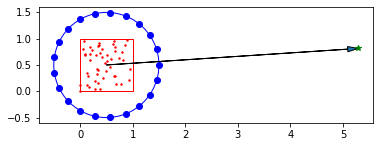

In [6]:
ax = plt.gca()
cell1.plot_cell_and_ring(ax)
plt.plot(target_coordinate[0], target_coordinate[1], marker='*', color='g')
plt.arrow(cell1.x, cell1.y, r*np.cos(theta), r*np.sin(theta),length_includes_head=True,
          head_width=0.1, head_length=0.2)
for p in tqdm(list_particles):
    p.plot()
ax.set_aspect('equal', adjustable='box')
plt.show()

Do the naive $O(N^2)$ direct summation as a reference.

In [7]:
direct_potential = Cell.direct_outside_potential(target_coordinate, list_particles)
direct_potential

79.15502508535326

### Outer Ring Approximation
Here we want to implement the outer ring approximation. For this, values like $\kappa$ and $\psi(a, s_i)$ which are calculated in the next block.

In [8]:
# Calculate the term marked as kappa in outer ring expansion term
cell1.eval_total_mass(list_cells, list_particles)
# Calculate the potential at the quadrature points(on ring) using direct nainve implementation
cell1.calculate_outer_ring_terms_leaf(list_particles)
cell1.outer_ring_expansion_terms

array([ 3.85206329,  3.01669129,  1.77164153,  0.47460221, -0.54168987,
       -1.42326248, -2.33231009, -3.18316598, -3.59779666, -3.33562316,
       -2.80569204, -2.52048648, -2.61993455, -2.54265743, -1.41312284,
        0.27521672,  1.84818025,  3.01332686,  3.74205343,  4.12603736,
        4.19558424])

***Task 1***
Implement the function `outer_ring_expansion(r, theta)`. This function should calculate the potential at point $(r, \theta)$ with respect to the center of the box using the outer ring exapansion. Have a look at the definition of a cell from above to see what properties are stored in the cell object since you will need them to compute the potential.

In [ ]:
# %load solution_task1_outerRing.py
def outer_ring_expansion(cell, r, theta):
    assert cell.kappa is not None, "Runtime Error: Total mass of individual cell is not yet calculated!"
    ################# Task 1 begins #########################
    term1 = cell.kappa * np.log(r)

    ratio = cell.a / r
    num = 1 - (ratio**2)
    den = 1 - (2 * ratio * np.cos(theta - cell.quad_angles)) + (ratio**2)
    f_s = cell.outer_ring_expansion_terms - (cell.kappa * np.log(cell.a))
    term2 = np.sum(f_s * num / den) * cell.h / (2 * np.pi)

    potential =  term1 + term2
    ################## Task 1 begins ########################
    return potential


Start the calculation and compare it to the direct sum. Use this to check your implementation.

In [10]:
# Calculate potential using outer ring expansion
outer_ring_potential = outer_ring_expansion(cell1, r, theta)

# Compare results
print("Direct Potential    : ", direct_potential)
print("Outer Ring potential: ", outer_ring_potential)
print("Absolute Difference : ", np.abs(outer_ring_potential - direct_potential))

Direct Potential    :  79.15502508535326
Outer Ring potential:  79.15501448053
Absolute Difference :  1.0604823259541263e-05


### Inner Ring Approximation
Let us create a box with center (5, 0.5) and side length of 1.
We will now calculate the potential at the same point as before but using inner ring approximation

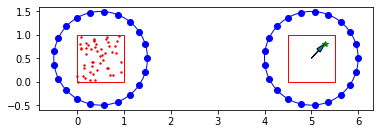

In [11]:
# Create the cell at (5, 0.5)
local_center = [5,0.5]
cell6 = Cell(100, M=10, center=local_center, side_length=1)

# Visualize the problem statement
ax = plt.gca()
cell1.plot_cell_and_ring(ax)
cell6.plot_cell_and_ring(ax)
plt.plot(target_coordinate[0], target_coordinate[1], marker='*', color='g')
# plt.arrow(cell1.x, cell1.y, r*np.cos(theta), r*np.sin(theta),length_includes_head=True,
#           head_width=0.1, head_length=0.2)
plt.arrow(cell6.x, cell6.y, target_coordinate[0] - cell6.x, target_coordinate[1] - cell6.y,
          length_includes_head=True, head_width=0.1, head_length=0.2)
for p in list_particles:
    p.plot()
ax.set_aspect('equal', adjustable='box')
plt.show()

First of all we will calculate the potential at the quadrature points of cell6 (center (5,0.5)) induced by particles inside the cell1 (center (0.5,05)). There are two methods to to that:

1. Direct potetntial calculation
2. Outer ring approximation of cell1

We will implement both. The potetial terms at the quadrarture point will be called **inner_ring_expansion_terms**.

***Task 2***
Implement the function `inner_ring_expansion(r, theta)`. This function should calculate the potential at point $(r, \theta)$ with respect to the center of the box using the inner ring exapansion. Have a look at [cell.py](cell.py) to see what properties are stored in the cell object since you will need them to compute the potential.

In [12]:
# %load solution_task2_innerRing.py
def inner_ring_expansion(cell, r, theta):
    ################ Task 2 begins #######################
    ratio = r / cell.a
    num = 1 - (ratio**2)
    den = 1 - (2 * ratio * np.cos(theta - cell.quad_angles)) + (ratio**2)

    potential = (np.sum(cell.inner_ring_expansion_terms * num / den) * cell.h / (2 * np.pi))




    ################ Task 2 ends ########################
    return potential


#### Method 1 Direct Potential calculation

In [13]:
cell6.inner_ring_expansion_terms = np.zeros(cell6.K, dtype=float)
for k in range(cell6.K):
    cell6.inner_ring_expansion_terms[k] = Cell.direct_outside_potential(cell6.quad_points[k], list_particles)

In [14]:
# Calculate the radial coordinates with respect to the center of the box
dx, dy = target_coordinate[0] - local_center[0], target_coordinate[1] - local_center[1]
r_inner = np.sqrt(dx**2 + dy**2)
theta_inner = math.atan2(dy,dx)

# Calculate inner ring potential
inner_ring_potential1 = inner_ring_expansion(cell6, r_inner, theta_inner)

# Compare results
print("Direct Potential    : ", direct_potential)
print("Inner Ring potential: ", inner_ring_potential1)
print("Difference          : ", np.abs(inner_ring_potential1 - direct_potential))

Direct Potential    :  79.15502508535326
Inner Ring potential:  79.15502507181172
Difference          :  1.3541537668970705e-08


#### Method 2 Outer Ring Approximation of cell1

In [15]:
cell6.inner_ring_expansion_terms = np.zeros(cell6.K, dtype=float)
for k in range(cell6.K):
    dx, dy = cell6.quad_points[k][0] - cell1.x, cell6.quad_points[k][1] - cell1.y
    r_inner = np.sqrt(dx**2 + dy**2)
    theta_inner = np.arctan(dy/dx)
    cell6.inner_ring_expansion_terms[k] = outer_ring_expansion(cell1, r_inner, theta_inner)

In [16]:
# Calculate the radial coordinates with respect to the center of the box
dx, dy = target_coordinate[0] - local_center[0], target_coordinate[1] - local_center[1]
r_inner = np.sqrt(dx**2 + dy**2)
theta_inner = math.atan2(dy,dx)

# Calculate inner ring potential
inner_ring_potential2 = inner_ring_expansion(cell6, r_inner, theta_inner)

# Compare results
print("Direct Potential    : ", direct_potential)
print("Inner Ring potential: ", inner_ring_potential2)
print("Difference          : ", np.abs(inner_ring_potential2 - direct_potential))

Direct Potential    :  79.15502508535326
Inner Ring potential:  79.15501446698846
Difference          :  1.0618364797210234e-05
